# Learning Through Target Spikes (LTTS - Figure 3

This notebook reproduces a variant (bu using spiking networks) of the results presented in `Figure 3` of the <a href="https://arxiv.org/abs/2201.11717">arXiv 2201.11717</a> preprint paper: Cristiano Capone<sup>\*</sup>, Cosimo Lupo<sup>\*</sup>, Paolo Muratore, Pier Stanislao Paolucci (2022) "*Burst-dependent plasticity and dendritic amplification support target-based learning and hierarchical imitation learning*". We test the `LTTB` model on a 3D-trajectory task.

Please give credit to this paper if you use or modify the code in a derivative work. This work is licensed under the Creative Commons Attribution 4.0 International License. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

### Libraries Import & Parameter Loading

In this section we import the needed external libraries and load the model parameters for this task (via the `json` configuration file).

In [1]:
import numpy as np
import random
from importlib import reload
from tqdm import trange

import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import lttb as lttb_module
from env import Unlock
from copy import deepcopy


In [2]:
with open ('./config.json', 'r') as fp:
    all_pars = json.load(fp)

env_par = all_pars['BUTTON_FOOD']
low_par = all_pars['LOW_NETWORK']
high_par = all_pars['HIGH_NETWORK']

tb = env_par['tb']
tf = env_par['tf']
rt = env_par['rt']
rb = env_par['rb']

env_par['hint'] = (env_par['hint']=="True")
env_par['clump'] = (env_par['clump']=="True")
env_par['validate'] = (env_par['validate']=="True")
env_par['verbose'] = (env_par['verbose']=="True")

n_examples = env_par['n_examples']

dt = low_par['dt']
tau_m = low_par['tau_m']

gamma = 1./low_par['du']
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)

half_eta = False

In [3]:
# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (env_par['dt'], env_par['dx']), res = 20)

trainset = np.array (env_par['trainset'])
validset = np.array (env_par['validset'])
testset  = np.linspace (*env_par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

# equally-spaced buttons and random food on a circle
if True:
    train_thetas = np.linspace(0,2*np.pi,n_examples,endpoint=False)
    train_thetas_targ = [random.random()*2*np.pi for i in range(n_examples)]

train_bttns = np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas])
train_targs = train_bttns + np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas_targ])

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (tb-1, tf-1), 'T' : (tb, tf)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]

#### Functions

In [4]:
def short_test_low():
    
    mses = np.zeros(n_examples)
    
    for example_index in range(n_examples):
        
        low_lttb.initialize(low_par)
        low_lttb.y_targ = low_lttb.y_targ_collection[example_index]
        low_lttb.I_clock = low_lttb.I_clock_collection[example_index]
        
        #run simulation
        for t in range(low_lttb.T-2):
            if(t<tb):
                low_lttb.cont = np.array([1,0])
            else:
                low_lttb.cont = np.array([0,1])
            low_lttb.step(apicalFactor = 0)
        
        #SR_low = low_lttb.B_filt[:,1:-2]
        SR_low = low_lttb.S_filtRO[:,1:-2]
        Y_low = low_lttb.Jout@SR_low
        mse_ro_train_low = np.std(low_lttb.y_targ[:,1:-2] - Y_low)**2
        
        mses[example_index] = mse_ro_train_low
    
    return mses

In [5]:
def short_test_high():
    
    mses = np.zeros(n_examples)
    
    for example_index in range(n_examples):
        
        high_lttb.initialize(high_par)
        high_lttb.y_targ = high_lttb.y_targ_collection[example_index]
        high_lttb.I_clock = high_lttb.I_clock_collection[example_index]
        
        #run simulation
        for t in range(high_lttb.T-2):
            high_lttb.cont = np.array([0])
            high_lttb.step(apicalFactor = 0)
        
        #SR_high = high_lttb.B_filt_rec[:,1:-2]
        SR_high = high_lttb.S_filtRO[:,1:-2]
        
        Y_high = high_lttb.Jout@SR_high + np.tile(high_lttb.Bias,(high_lttb.T-3,1)).T
        mse_ro_train_high = np.std(high_lttb.y_targ[:,1:-2] - Y_high)**2
        
        mses[example_index] = mse_ro_train_high
    
    return mses

In [6]:
def training_low(nIterRec=100, test_every=5, eta=5., eta_out=0.01, eta_W=0., eta_bias=0.0002, verbose=True):
    
    ERRORS_low = np.zeros((int(nIterRec/test_every),n_examples))
    
    iterator = trange(nIterRec, desc = 'LTTB Low Network Training', leave = True)
    
    for iteration in iterator:
        
        #initialize simulation
    
        for example_index in range(n_examples):
            
            low_lttb.y_targ = low_lttb.y_targ_collection[example_index]
                
            #ON-LINE
                
            low_lttb.initialize(low_par)
            low_lttb.I_clock = low_lttb.I_clock_collection[example_index]
                
            #run simulation
            dH = 0
                
            for t in range(low_lttb.T-2):
                    
                if(t<tb):
                    low_lttb.cont = np.array([1,0])
                else:
                    low_lttb.cont = np.array([0,1])
                low_lttb.step(apicalFactor = 1)
                    
                #SR_low = low_lttb.B_filt[:,t+1]
                SR_low = low_lttb.S_filtRO[:,t+1]
                Y_low = low_lttb.Jout@SR_low
                DJRO = np.outer(low_lttb.y_targ[:,t+1] - Y_low,SR_low.T)
                low_lttb.Jout = low_lttb.Jout + eta_out*DJRO
           
        ###### Test
        
        if (iteration+1)%test_every==0:
            
            mses = short_test_low()
            
            ERRORS_low[int(iteration/test_every),:] = mses
            
            if verbose:
                msg = 'LTTB Low Network Training. <MSE>: %.4f' % np.mean(mses)
                iterator.set_description(msg)

    return ERRORS_low

In [7]:
def training_high(nIterRec=100, test_every=5, eta=5., eta_out=0.01, eta_W=0., eta_bias=0.0002, verbose=True):
    
    ERRORS_high = np.zeros((int(nIterRec/test_every),n_examples))
    
    iterator = trange(nIterRec, desc = 'LTTB High Network Training', leave = True)
    
    
    
    for iteration in iterator:

    #initialize simulation
    
        for example_index in range(n_examples):
        
            high_lttb.y_targ = high_lttb.y_targ_collection[example_index]
        
            #ON-LINE
            
            high_lttb.initialize(high_par)
            high_lttb.I_clock = high_lttb.I_clock_collection[example_index]
            
            high_lttb_copy = deepcopy(high_lttb)
            high_lttb_copy.w*=0
            high_lttb_copy.J*=0
            
            #run simulation
            dH = 0
            
            high_lttb_copy.initialize(high_par)
            
            for t in range(high_lttb.T-2):
                
                high_lttb_copy.cont = np.array([0])
                high_lttb_copy.step(apicalFactor = 0, basalFactor = 1)
                
            high_lttb.S_targ = high_lttb_copy.S_filtRO
            
            high_lttb.initialize(high_par)
            
            dH = 0
                
                
            for t in range(high_lttb.T-2):
                
                high_lttb.cont = np.array([0])
                high_lttb.step(apicalFactor = 0, basalFactor = 0)
                
                dH = dH*(1-dt/tau_m) + dt/tau_m*high_lttb.S_filt[:,t]
                #DJ = np.outer( ( high_lttb.S_apic_dist[:,t+1] - f(high_lttb.VapicRec[:,t],gamma) )*(1-high_lttb.S_apic_prox[:,t])*high_lttb.S_wind_soma[:,t+1] ,dH)
                Dw = np.outer( ( high_lttb.S_targ[:,t+1] - high_lttb.S_filtRO[:,t+1] )*(1-high_lttb.S_soma[:,t]) ,dH)
                
                #high_lttb.J =  high_lttb.J + eta*DJ
                high_lttb.w =  high_lttb.w + eta*Dw
                    
                #SR_high = high_lttb.B_filt_rec[:,t+1]
                SR_high = high_lttb.S_filtRO[:,t+1]
                Y_high = high_lttb.Jout@SR_high + high_lttb.Bias
                
                DJRO = np.outer(high_lttb.y_targ[:,t+1] - Y_high,SR_high.T)
                dBias = high_lttb.y_targ[:,t+1] - Y_high
                
                high_lttb.Jout = high_lttb.Jout + eta_out*DJRO
                high_lttb.Bias = high_lttb.Bias + eta_bias*dBias
            
            #print(np.std(high_lttb.S_targ - high_lttb.S_filtRO))
        
        ###### Test
    
        if (iteration+1)%test_every==0:
        
            mses = short_test_high()
            
            ERRORS_high[int(iteration/test_every),:] = mses
        
            if verbose:
                msg = 'LTTB High Network Training. <MSE>: %.4f' % np.mean(mses)
                iterator.set_description(msg)


    return ERRORS_high

In [8]:
def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

#### Low network

In [9]:
print(low_par['sigma_in'])

low_par['sigma_in']*=2

low_lttb = lttb_module.LTTB(low_par)

low_lttb.y_targ_collection = []
low_lttb.I_clock_collection = []

for k in range(n_examples):
    low_lttb.y_targ_collection.append(train_exp[k][1])
    low_lttb.I_clock_collection.append(train_exp[k][0])

#low_lttb.j_apical_cont[0:int(low_par['Ne']/2),1] = 0
#low_lttb.j_apical_cont[int(low_par['Ne']/2):,0] = 0
#low_lttb.j_apical_cont[low_par['Ne']:,:] = 0

#low_lttb.j_apical_cont *= 0

low_lttb.sigma_apical_cont = 0
low_lttb.sigma_basal_cont = 100

low_lttb.j_basal_cont[0:int(low_par['Ne']/2),1] = 0
low_lttb.j_basal_cont[int(low_par['Ne']/2):,0] = 0
low_lttb.j_basal_cont[low_par['Ne']:,:] = 0

ERRORS_low = []

eta_low = low_par['eta']
eta_out_low = low_par['eta_out']

20


In [10]:
nEpochs = 2
N_ITER_REC = 20

low_lttb.T = 120
#high_lttb.T = 120

for epoch in range(nEpochs):
    ERRORS_low.extend(training_low(nIterRec=N_ITER_REC, eta=eta_low, eta_out=eta_out_low/4., eta_bias=0))
    if half_eta:
        eta_low /= 2
        eta_out_low /= 2

LTTB Low Network Training. <MSE>: 0.3110: 100%|██████████| 20/20 [05:03<00:00, 15.20s/it]


#### High network

In [11]:
high_lttb = lttb_module.LTTB(high_par)

high_lttb.y_targ_collection = []
high_lttb.I_clock_collection = []

high_targ = np.array([[1. if t<tb else 0. for t in range(tb+tf)],[0. if t<tb else 1. for t in range(tb+tf)]])

for k in range(n_examples):
    high_lttb.y_targ_collection.append(high_targ)
    high_lttb.I_clock_collection.append(train_exp[k][0]) # same as low network

high_lttb.j_apical_cont[:,:] = 0

high_lttb.sigma_apical_cont = 0
high_lttb.sigma_basal_cont = 0

ERRORS_high = []

eta_high = high_par['eta']
eta_out_high = high_par['eta_out']

In [12]:
nEpochs = 0
N_ITER_REC = 1
high_lttb.T = 120

for epoch in range(nEpochs):
    ERRORS_high.extend(training_high(nIterRec=N_ITER_REC, eta=eta_high, eta_out=eta_out_high/2., eta_bias=0.0002))
    #if half_eta:
    #    eta_high /= 2
    #    eta_out_high /= 2

#### Check the training

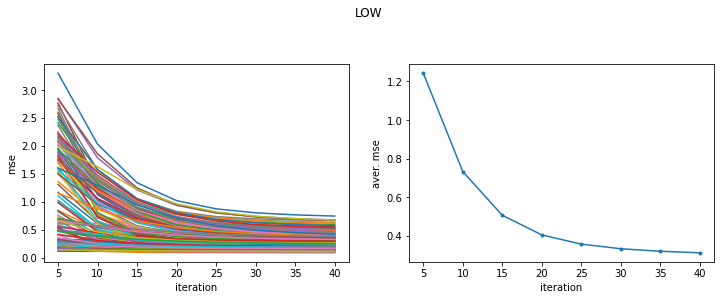

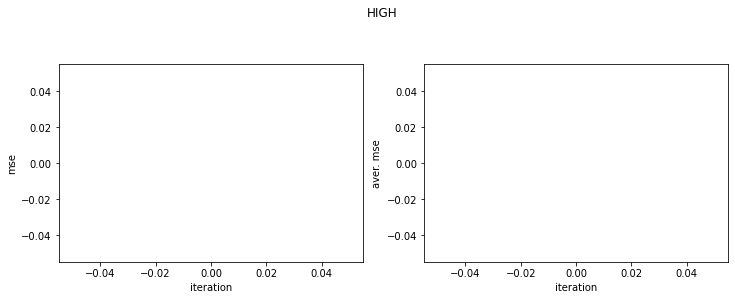

In [13]:
plt.figure(figsize=(12, 8))
plt.suptitle('LOW')

plt.subplot(221)
plt.plot(5*np.arange(1,1+len(ERRORS_low)),ERRORS_low)
plt.xlabel("iteration")
plt.ylabel("mse")

plt.subplot(222)
plt.plot(5*np.arange(1,1+len(ERRORS_low)),[np.mean(ERRORS_low[_]) for _ in range(len(ERRORS_low))], marker='.')
plt.xlabel("iteration")
plt.ylabel("aver. mse")

plt.show()

plt.figure(figsize=(12, 8))
plt.suptitle('HIGH')

plt.subplot(221)
plt.plot(5*np.arange(1,1+len(ERRORS_high)),ERRORS_high)
plt.xlabel("iteration")
plt.ylabel("mse")

plt.subplot(222)
plt.plot(5*np.arange(1,1+len(ERRORS_high)),[np.mean(ERRORS_high[_]) for _ in range(len(ERRORS_high))], marker='.')
plt.xlabel("iteration")
plt.ylabel("aver. mse")

plt.show()

In [14]:
def make_test(btn, targ, show_plot=True, use_HighNetwork=True,closed_loop = True,verbose=False):
    #use_HighNetwork = False
    TIME_TEST = 1500
    
    t_reach_btn = TIME_TEST
    t_reach_targ = TIME_TEST
    
    low_par['T'] = TIME_TEST
    low_lttb.T = TIME_TEST
    low_lttb.init_clock(low_par)
    low_lttb.initialize(low_par)
    low_lttb.y_targ = np.zeros((low_lttb.O,low_lttb.T))
    
    if use_HighNetwork:
        high_par['T'] = TIME_TEST
        high_lttb.T = TIME_TEST
        high_lttb.init_clock(high_par)
        high_lttb.initialize(high_par)
        high_lttb.y_targ = np.zeros((high_lttb.O,high_lttb.T))
    
    btn_radius = 0.15
    
    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init=init, targ=targ, btn=btn)

    agen = init
    
    #cont_noise = 0.05#0.05
    
    #print(cont_noise)
    
    R = 0

    ACTIONS = []
    ACTIONS_HIGH = []
    POSITION = []

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))
    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    
    low_lttb.I_clock[:,0] = state
    low_lttb.cont = np.array([1,0])
    
    if use_HighNetwork:
        high_lttb.I_clock[:,0] = state
        high_lttb.cont = np.array([0])

    context = []

    btn_on = False
    
    for t in range (TIME_TEST-2):
        
        if not use_HighNetwork:
            
            if not btn_on:
                low_lttb.cont = np.array([1,0]) + np.random.normal(loc=0, scale=cont_noise, size=2)
            else:
                low_lttb.cont = np.array([0,1]) + np.random.normal(loc=0, scale=cont_noise, size=2)
            
            if closed_loop:
                low_lttb.I_clock[:,low_lttb.t+1] = state
                if np.sqrt( np.sum((agen - btn)**2) ) < btn_radius:
    
                    btn_on = True
                    t_reach_btn = t
                    low_lttb.cont = np.array([0,1]) + np.random.normal(loc=0, scale=cont_noise, size=2)
    
            else:
                low_lttb.I_clock[:,lttb.t+1] = low_lttb.I_clock_collection[cont_index][:,low_lttb.t+1]
                
                if(t<tb):
                    low_lttb.cont = np.array([1,0]) + np.random.normal(loc=0, scale=cont_noise, size=2)
                else:
                    low_lttb.cont = np.array([0,1]) + np.random.normal(loc=0, scale=cont_noise, size=2)

        else:
            
            Y_high = high_lttb.Jout@high_lttb.S_filtRO[:,t] + high_lttb.Bias
            if Y_high[0] > Y_high[1]:
                low_lttb.cont = np.array([1,0])
            else:
                low_lttb.cont = np.array([0,1])
            #low_lttb.cont = Y_high
            
            if closed_loop:
                low_lttb.I_clock[:,low_lttb.t+1] = state
                high_lttb.I_clock[:,high_lttb.t+1] = state
                if np.sqrt( np.sum((agen - btn)**2) ) < btn_radius:
                    btn_on = True
                    t_reach_btn = t
            else:
                low_lttb.I_clock[:,low_lttb.t+1] = low_lttb.I_clock_collection[cont_index][:,low_lttb.t+1]
                high_lttb.I_clock[:,high_lttb.t+1] = high_lttb.I_clock_collection[cont_index][:,high_lttb.t+1]
            
        context.append(low_lttb.cont)

        low_lttb.step (apicalFactor = 0)
        if use_HighNetwork:
            high_lttb.step (apicalFactor = 0)
            
            #ACTIONS_HIGH.append(high_lttb.Jout@high_lttb.B_filt_rec[:,t] + high_lttb.Bias)
            ACTIONS_HIGH.append(high_lttb.Jout@high_lttb.S_filtRO[:,t] + high_lttb.Bias)
            
        action = low_lttb.Jout@low_lttb.S_filtRO[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        POSITION.append( list(agen) )

        R = max (R, r)
        

        if np.sqrt( np.sum((agen - targ)**2) )  < 0.1 and btn_on:
            done = True
            t_reach_targ = t

        if done:
            break
            
    #R = min(R,10)/10
    
    #print(R)

    
    min_btn_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - btn)**2) ) for _ in range(len(POSITION))])
    min_targ_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - targ)**2) ) for _ in range(len(POSITION))])
    
    if verbose==True:
        print('btn_theta = %.3f' % btn_theta)
        print('R = %.3f' % R)
        print('min_btn_dist = %.3f' % min_btn_dist)
        print('t_reach = [%d,%d]' % (t_reach_btn,t_reach_targ))
    
    if show_plot:
        plt.figure()
        plt.scatter(0,0,marker='X',color='black')
        plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
        plt.plot(targ[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
        plt.plot(btn[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
        plt.xlim(-2.2,2.2)
        plt.ylim(-2.2,2.2)
        plt.show()
    
    res = {}
    res['POSITION'] = POSITION
    res['ACTIONS'] = ACTIONS
    if use_HighNetwork:
        res['ACTIONS_HIGH'] = ACTIONS_HIGH
    res['context'] = context
    res['S_soma'] = low_lttb.S_soma
    res['S_wind'] = low_lttb.S_wind
    res['B_filt'] = low_lttb.B_filt
    res['R'] = R
    res['min_btn_dist'] = min_btn_dist
    res['min_targ_dist'] = min_targ_dist
    res['t_reach_btn'] = t_reach_btn
    res['t_reach_targ'] = t_reach_targ
    
    return res



In [15]:
def mean_test(n_test=20,use_HighNetwork = True,if_plot=False):
    
    Rs = []
    Rs_timeResc = []
    btn_dists = []
    targ_dists = []
    
    for n in range(n_test):

        btn_theta = random.random()*2*np.pi
        targ_theta = random.random()*2*np.pi

        btn_dist = 1.0
        targ_dist = 1.0

        btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
        targ_test = np.array(btn_test) + np.array((btn_dist * np.cos (targ_theta), btn_dist * np.sin (targ_theta)))

        res = make_test(btn_test, targ_test, show_plot=if_plot, use_HighNetwork=use_HighNetwork)

        Rs.append(res['R'])
        #Rs_timeResc.append(res['R_timeResc'])
        btn_dists.append(res['min_btn_dist'])
        targ_dists.append(res['min_targ_dist'])
    
    R_mean = np.mean(Rs)
    R_std = np.std(Rs)
    
    btn_dist_mean = np.mean(btn_dists)
    targ_dist_mean = np.mean(targ_dists)
    button_rate = len([_ for _ in Rs if _>0])/len(Rs)
    food_rate = len([_ for _ in Rs if _==1])/len(Rs)
    
    return R_mean, R_std , btn_dist_mean, targ_dist_mean, button_rate, food_rate



0.0
0


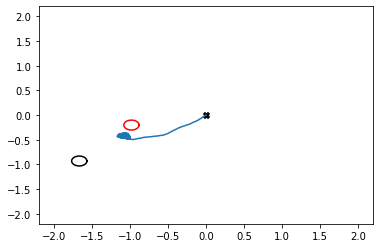

In [16]:
cont_noise=0.
btn_theta = random.random()*2*np.pi
targ_theta = random.random()*2*np.pi

btn_dist = 1.0
targ_dist = 1.0

btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
targ_test = np.array(btn_test) + np.array((btn_dist * np.cos (targ_theta), btn_dist * np.sin (targ_theta)))
res = make_test(btn_test, targ_test, show_plot=True, use_HighNetwork=False)

In [17]:
R_coll = []
R_coll_std = []

for values in [0.,0.1,1.,10.,100.]:
    cont_noise = values
    R_mean, R_std,btn_dist_mean, targ_dist_mean, button_rate, food_rate = mean_test(n_test=50, use_HighNetwork=False,if_plot=False)
    R_coll.append(R_mean)
    R_coll_std.append(R_std)
    

0.0
0
0.0
1
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
1
0.0
1
0.0
1
0.0
0
0.0
1
0.0
0
0.0
1
0.0
1
0.0
1
0.0
1
0.0
0
0.0
0
0.0
1
0.0
0
0.0
1
0.0
1
0.0
0
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
0
0.0
0
0.0
1
0.0
0
0.0
1
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
0.0
1
0.1
1
0.1
0
0.1
0
0.1
0
0.1
1
0.1
0
0.1
0
0.1
1
0.1
0
0.1
1
0.1
1
0.1
0
0.1
1
0.1
1
0.1
1
0.1
1
0.1
1
0.1
1
0.1
0
0.1
0
0.1
1
0.1
1
0.1
1
0.1
0
0.1
0
0.1
1
0.1
1
0.1
1
0.1
0
0.1
1
0.1
1
0.1
0
0.1
1
0.1
0
0.1
1
0.1
0
0.1
0
0.1
0
0.1
1
0.1
1
0.1
0
0.1
1
0.1
0
0.1
0
0.1
1
0.1
0
0.1
1
0.1
1
0.1
1
0.1
1
1.0
1
1.0
0
1.0
0
1.0
0
1.0
0
1.0
0
1.0
1
1.0
0
1.0
0
1.0
1
1.0
0
1.0
1
1.0
0
1.0
1
1.0
1
1.0
1
1.0
0
1.0
1
1.0
1
1.0
0
1.0
1
1.0
1
1.0
1
1.0
1
1.0
1
1.0
1
1.0
1
1.0
0
1.0
0
1.0
1
1.0
0
1.0
0
1.0
1
1.0
0
1.0
1
1.0
1
1.0
0
1.0
1
1.0
1
1.0
1
1.0
1
1.0
1
1.0
1
1.0
0
1.0
1
1.0
1
1.0
1
1.0
1
1.0
1
1.0
0
10.0
0.5575179478257779
10.0
0
10.0
0
10.0
1
10.0
0
10.0
1
10.0
1
10.0
0
10.0
0
10.0
0
10.0
0
10.0
0

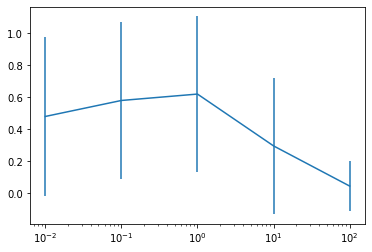

In [18]:
plt.errorbar([0.01,0.1,1.,10.,100.],R_coll,R_coll_std)
plt.xscale('log')

np.save('../Rew_ltts_mean_0.npy',R_coll)
np.save('../Rew_ltts_std_0.npy',R_coll_std)